The interactive version of this notebook is available at https://github.com/TheAxonLab/hcph-sops/tree/mkdocs/docs/analysis

## Load data and extract parameters

In [1]:
import nibabel as nb
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

### Locate all the QCT functional scans and corresponding files

Our dataset, called the Human Connectome Phantom (HCPh) dataset, contains 36 sessions and each session has been acquired on a single healthy individual with the same acquisition protocol. One of the scans acquired during those sessions is a BOLD task fMRI. The task named Quality-Control Task (QCT) comprises four paradigms: a central fixation dot (blank), gaze movement, visual grating patterns, and finger-tapping (left/right). We ran our dataset through *fMRIPrep* to preprocess the data and extract confounds that we will use to denoise the data. We also generated the events file that lists the onset and duration of each stimuli from the task files output by *Psychopy*. Let us locate all the files that we need using the convenient BIDS interface implemented in *Nilearn*.

In [2]:
# Nilearn works well with file paths and there's a nice BIDS interface implemented
from nilearn.interfaces import bids as nibids

# This will work if the "fmriprep" dir is a valid BIDS dataset
# (requires to have "sub-###" directories and a "dataset_description.json")
path_to_dataset = Path("/data/datasets/hcph")
path_to_derivatives = Path("/data/derivatives/hcph-derivatives/fmriprep-23.2.2-wp")

# Load the T1w images so we can plot activity on top
t1w = path_to_derivatives / "sub-001/anat/sub-001_acq-undistorted_desc-preproc_T1w.nii.gz"

# Load the QCT functional scans
qct_files = nibids.get_bids_files(
    path_to_derivatives, file_tag="bold", file_type="nii.gz", filters=[("task", "qct")]
)
#Keep only the files with no space entity, that is the file in BOLD native space (filtering with ("space", None) did not work on the previous line)
qct_files = [file for file in qct_files if 'space-' not in file]

# Load the QCT events
qct_events_all = nibids.get_bids_files(
    path_to_dataset, file_tag="events", file_type="tsv", filters=[("task", "qct")]
)

# Filter out pilot and excluded sessions, as well as session for which fMRIPrep did not run
qct_events = []
for element in qct_events_all:
    if (
        "ses-0" in element
    ):
        qct_events.append(element)

"""
# Code useful to understand why we do not have the same number of events than files
import re
match_events = set([re.search(r'ses-0\d\d', s).group() if re.search(r'ses-0\d\d', s) else None for s in qct_events])
match_files = set([re.search(r'ses-0\d\d', s).group() if re.search(r'ses-0\d\d', s) else None for s in qct_files])
print(match_events.symmetric_difference(match_files))
"""

print(len(qct_events))
print(len(qct_files))

36
36


### Extract acquisition parameters

For building the model of the BOLD during task, we need to extract the timing of acquisition which depends on the TR and the number of volumes, so let us extract those parameters using *nibabel*.

In [3]:
# Extract acquisition parameters
tr = []
n_scans = []
for file in qct_files:
    fmri = nb.load(file)
    tr.append(fmri.header.get_zooms()[3])
    n_scans.append(fmri.shape[3])

#### Quality control of acquisition parameters

In our single-site dataset, all sessions have been acquired at the same site with the same acquisition protocol. As such, we have to check that all functional scans have the same repetition time (TR) and the same number of volumes. A deviation in TR or number of volumes has to be investigated further to understand what happened and the scan might need to be excluded.

In [4]:
print(tr)
print(n_scans)

[1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6]
[99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]


Good news! All the scans have the same TR and the same number of volumes. Let's simplify notation by storing only one `tr` and one `n_samples` value. Additionally, now that those two parameters are defined, we can extract the acquisition timing.

In [5]:
tr = tr[0]
n_scans = n_scans[0]
frame_times = np.arange(n_scans) * tr

### Extract confounds

fMRI data are notoriously noisy, as such we need to perform denoising through a process known as nuisance regression. *fMRIPrep* conveniently compute a series of regressors that you might want to remove from your signal. Thus, let us load some confounds from *fMRIPrep* derivatives for using them later.

In [6]:
# Nilearn also has a nice fMRIPrep interface implemented that we will use 
# to load some confounds extracted by the tool
from nilearn.interfaces import fmriprep

qct_confounds, qct_sample_masks = fmriprep.load_confounds(
    qct_files,
    strategy=["motion", "wm_csf", "scrub"],
    motion="basic",
    wm_csf="basic",
    scrub=5,
    fd_threshold=0.4,
    std_dvars_threshold=1.5,
)

## Extract activation maps for each subject

### Put together design matrix

To get information about what regions of the brain are activated during a certain task, you must first know when the task of interest was happening during the scan. The information about the timing of each task is stored as columns (one per task plus other derivatives) in a matrix called design matrix. We use *nilearn* to compute the design matrix from the events files.

In [7]:
from nilearn.glm.first_level import make_first_level_design_matrix

hrf_model = "glover"

design_matrices = []
for filename, confounds in zip(qct_events, qct_confounds):
    # Load the event file as a dataframe
    event = pd.read_csv(filename, sep="\t")

    # Remove eye-tracker related event as they are of no interest here 
    event = event[(event['trial_type'] != 'et-record-on') & (event['trial_type'] != 'et-record-off')]

    # Construct design matrix
    design_matrices.append(
        make_first_level_design_matrix(
            frame_times, event, hrf_model=hrf_model, add_regs=confounds
        )
    )

/home/cprovins/.local/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: value
  warnings.warn(
/home/cprovins/.local/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: value
  warnings.warn(
/home/cprovins/.local/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: value
  warnings.warn(
/home/cprovins/.local/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: value
  warnings.warn(
/home/cprovins/.local/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ig

Note the warning that has been emitted by the `make_first_level_design_matrix` : "UserWarning: The following unexpected columns in events data will be ignored: value", we will come back to it later. 

Let us now have a look at one design matrix as an example. In a event-related design like here, the design matrices are constructed by convolving a Haemodynamic Response Function (HRF) with timeseries indicative of tasks' onset and duration. As such, we expect peaks around the time of stimuli presentation with a smooth transition around that peak.

<Figure size 300x300 with 0 Axes>

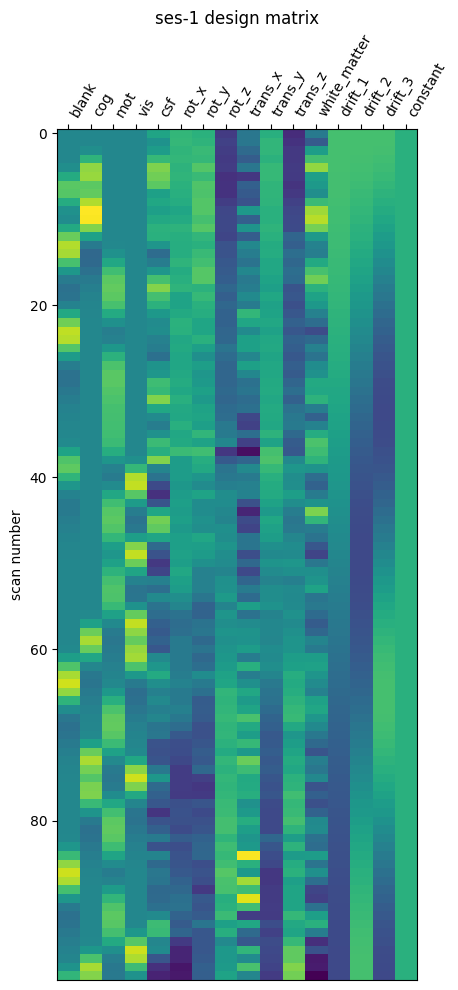

In [8]:
from nilearn.plotting import plot_design_matrix

plt.figure(figsize=(3, 3))

plot_design_matrix(design_matrices[0])
plt.title("ses-1 design matrix", fontsize=12)

# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Show the plot
plt.show()

Note that we indicated the model to take into account confounds (e.g. motion parameters `rot*` and `trans*`), so they appear in the design matrix alongside the task regressors (`blank`,`cog`, `mot` and `vis`). 

It seems that the task regressors do present the pattern we were refering to, but it is not very clear. A clearer way to visualize this is to plot the task regressors as timeseries. 

<Figure size 300x300 with 0 Axes>

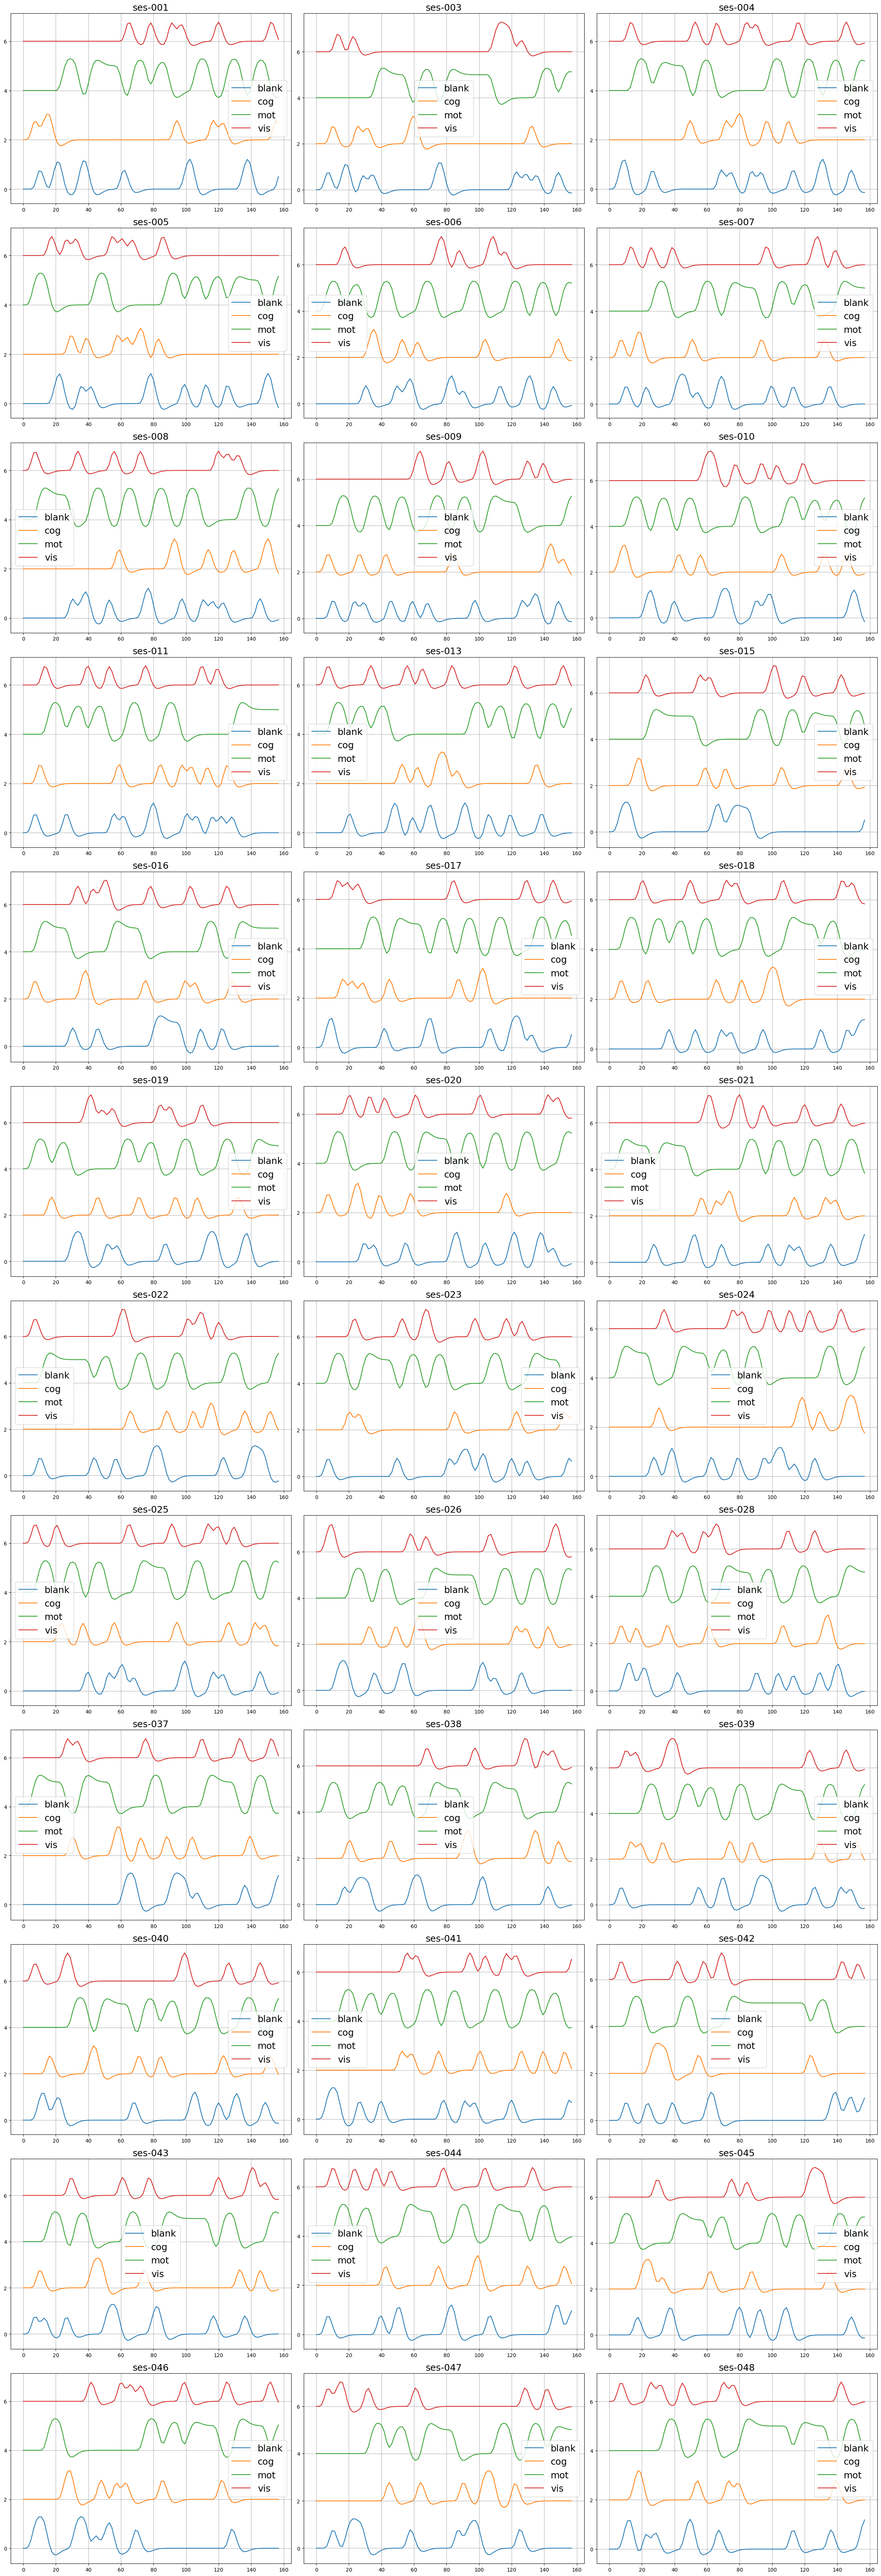

In [9]:
import re

# Quick check of the event models in signal plots
plt.figure(figsize=(3, 3))
fig, axs = plt.subplots(12, 3, figsize=(24, 70))

events_sessions = [
    re.search(r"ses-0\d\d", s).group() if re.search(r"ses-0\d\d", s) else None
    for s in qct_events
]

# Plot task regressors for each QCT scans
for i, (design_matrix, ses) in enumerate(zip(design_matrices, events_sessions)):
    space_between_lines = 2
    # Just plot the task regressors not the confounds
    dm_subset = design_matrix[["blank", "cog", "mot", "vis"]]
    for j, column in enumerate(dm_subset):
        axs.flat[i].plot(
            dm_subset.loc[:, column] + j * space_between_lines, label=column
        )

    axs.flat[i].set_title(ses, fontsize=18)
    axs.flat[i].set_yticks(np.arange(dm_subset.shape[1]) * space_between_lines)
    axs.flat[i].grid()
    axs.flat[i].legend(fontsize=18)

# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Show the plot
ax = plt.show()

Now it is clear that the tasks' presentation are encoded as a smoothly increasing and decreasing peak in the regressors, the shape that is imposed by the HRF. As such, the design matrix seems to be correctly built.

However, going back to the design matrix, you should notice that there are only four task regressors, yet in our events files we encoded the different instances of the tasks (e.g. left versus right-hand fingertapping). This is when the warning that we noticed earlier becomes relevant! The function `make_first_level_design_matrix` just ignored the column `value` that contains those extra information. As such, the design matrix does not make the difference between different instances of the tasks. Yet, we know that e.g. left or right fingertapping will activate regions in opposite hemispheres. So depending on your question, you might want to decouple those two instances of the task. Let us do this by merging the content of `value` into `trial_type`.

In [10]:
from nilearn.glm.first_level import make_first_level_design_matrix

hrf_model = "glover"

design_matrices_detailed = []

for filename, confounds in zip(qct_events, qct_confounds):
    # Load the event file as a dataframe
    event = pd.read_csv(filename, sep="\t")

    # Remove eye-tracker related event as they are of no interest here 
    event = event[(event['trial_type'] != 'et-record-on') & (event['trial_type'] != 'et-record-off')]
    
    # Build a detailed event dataframe separating 
    # event type (such as Left or Right for the motor task)
    event_detailed = event.copy()

    fix_points = event_detailed.loc[event.trial_type == "cog", "value"].unique()
    fix_point_to_fix_name = {}
    for i, fix_pt in enumerate(fix_points):
        fix_point_to_fix_name.update({fix_pt: f"fix_point_{i+1:02d}"})

    event_detailed.loc[event.trial_type == "cog", "value"] = event.loc[
        event.trial_type == "cog", "value"
    ].map(fix_point_to_fix_name)

    cog_mot_events = event.trial_type.isin(["cog", "mot"])
    event_detailed.loc[cog_mot_events, "trial_type"] = (
        event_detailed.loc[cog_mot_events, "trial_type"]
        + "_"
        + event_detailed.loc[cog_mot_events, "value"]
    )

    # Construct design matrix
    design_matrices_detailed.append(
        make_first_level_design_matrix(
            frame_times,
            event_detailed.drop(columns=["value"]),
            hrf_model=hrf_model,
            add_regs=confounds,
        )
    )

Now let us compare the design matrix with and without the detailed information.

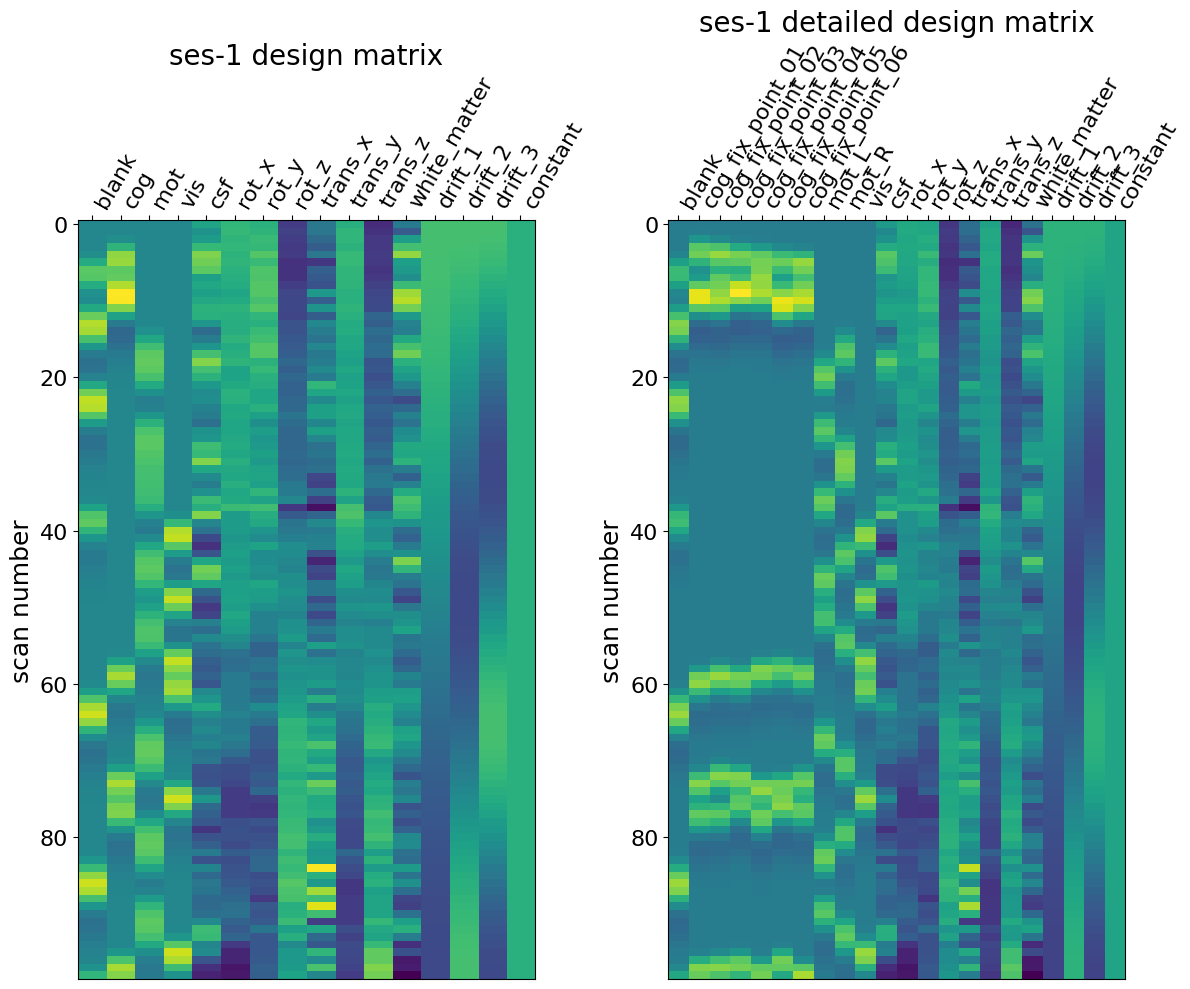

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

for i, (design_matrix, matrix_suffix) in enumerate(
    zip([design_matrices[0], design_matrices_detailed[0]], ["", "detailed "])
):
    plot_design_matrix(design_matrix, ax=axs.flat[i])
    axs.flat[i].set_title(f"ses-1 {matrix_suffix}design matrix", fontsize=20)
    axs.flat[i].yaxis.label.set_fontsize(18)
    axs.flat[i].tick_params(axis="x", labelsize=16)
    axs.flat[i].tick_params(axis="y", labelsize=16)


# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Show the plot
plt.show()

We now have 6 columns for the cognitive task corresponding to the 6 different fixation points, 2 columns for the motor task corresponding to left and right-hand fingertapping, 1 column for the visual task and 1 column for the blank condition. The detailed design matrices is the one we will use in the rest of this notebook.

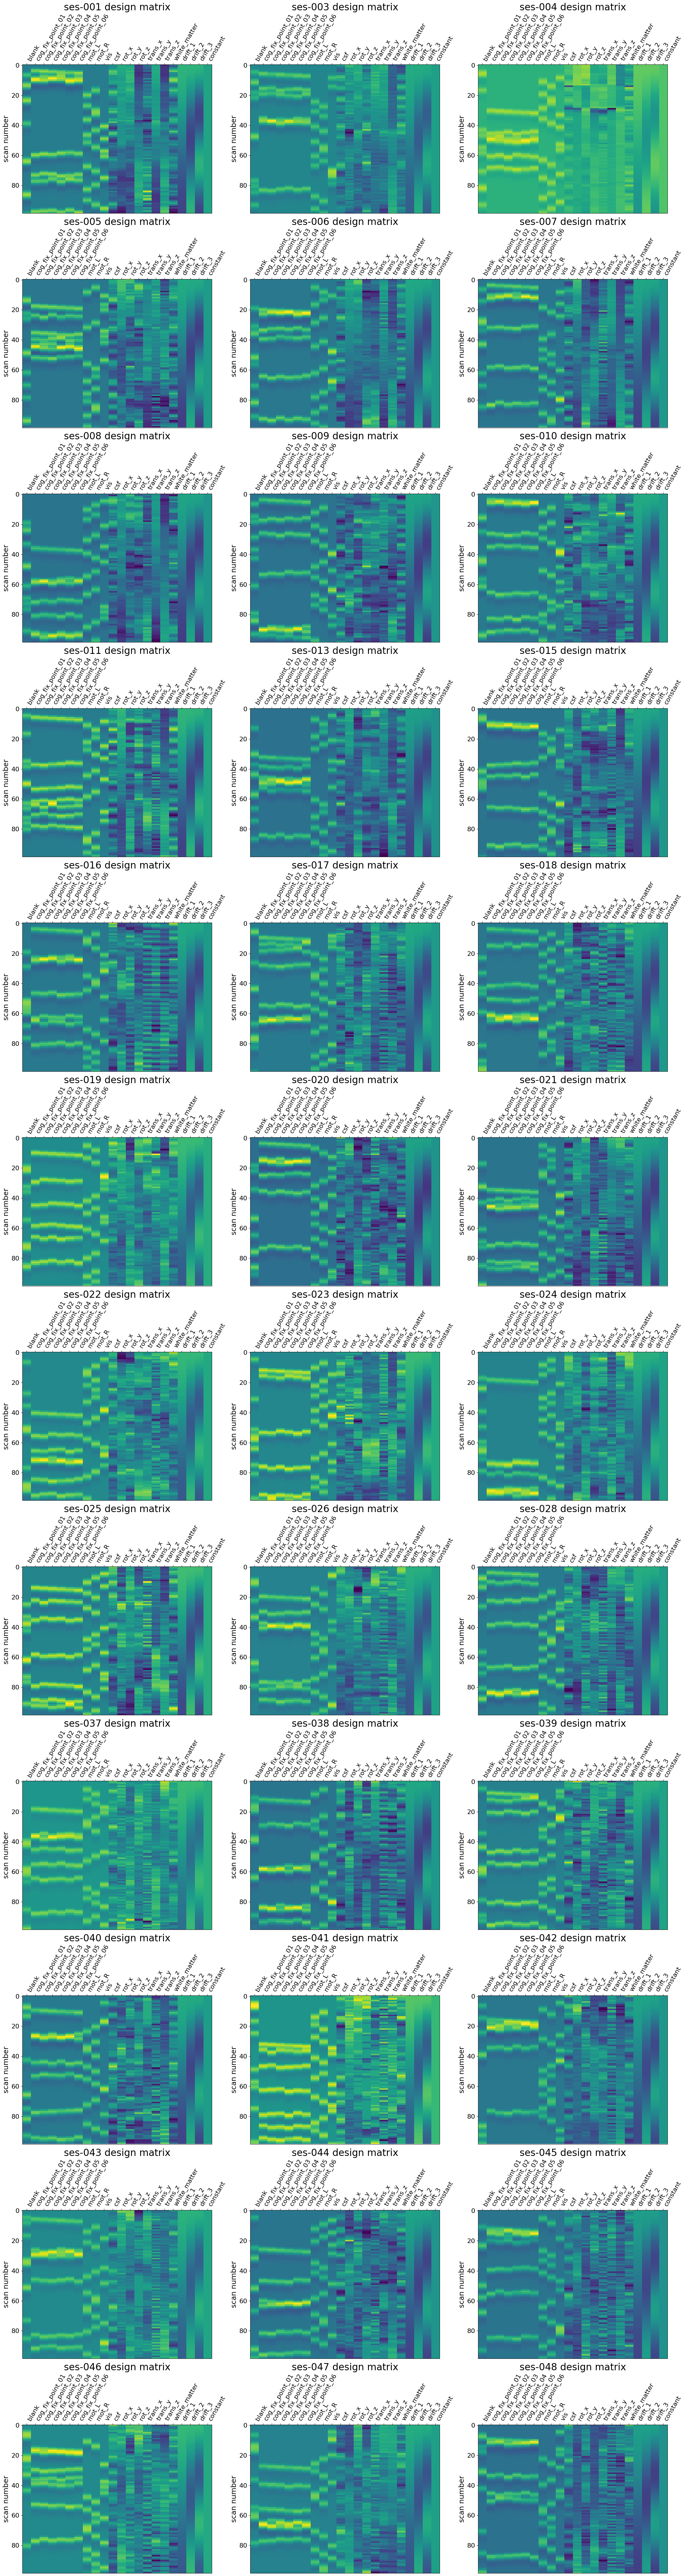

In [12]:
fig, axs = plt.subplots(12, 3, figsize=(24, 90))

# Add some content to each subplot (for demonstration purposes)
for i, (design_matrix, ses_name) in enumerate(
    zip(design_matrices_detailed, events_sessions)
):
    plot_design_matrix(design_matrix, ax=axs.flat[i])
    axs.flat[i].set_title(f"{ses_name} design matrix", fontsize=24)
    axs.flat[i].yaxis.label.set_fontsize(18)
    axs.flat[i].tick_params(axis="x", labelsize=16)
    axs.flat[i].tick_params(axis="y", labelsize=16)

# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Show the plot
plt.show()

### Fit GLM

Now that we have the design matrix for each QCT fMRI scan in our dataset, we can fit the generalized linear model (GLM) to the BOLD data.

In [14]:
# Load images
imgs = []
for file in qct_files:
    img = nb.load(file)
    imgs.append(img)

Now that we corrected the affine, we can fit the first-level GLM to the data.

In [15]:
# Ignore FutureWarning
from nilearn.glm.first_level import FirstLevelModel
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Extract reference affine and shape
ref_affine = imgs[0].affine
ref_shape = imgs[0].shape[:-1]

first_level_models = []
for img, design_matrix, sample_mask in zip(
    imgs, design_matrices_detailed, qct_sample_masks
):
    # Input reference affine and shape so that images are resampled to the same space before comparing voxels
    first_level_model = FirstLevelModel(
         n_jobs=1, target_affine= ref_affine, target_shape = ref_shape, smoothing_fwhm=4
     )
     
    first_level_model = first_level_model.fit(
        img, design_matrices=design_matrix, sample_masks=sample_mask
    )
    first_level_models.append(first_level_model)

len(first_level_models)

/home/cprovins/.local/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/cprovins/.local/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/cprovins/.local/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the ma

36

Note the warning: because we are working with images in subject space, it is necessary to resample them to the same space before comparing voxels activations in the first-level model. This ensures that each voxel corresponds to the same physical location in the brain across all images, so that voxel-wise comparisons are accurate.

An essential element for the reliability of neuroimaging studies is to quality control your images at several steps in the analysis pipeline. As such, let us look at the first-level statistical map contrasting the fingertapping to the blank condition to check that the activation maps are meaningful.

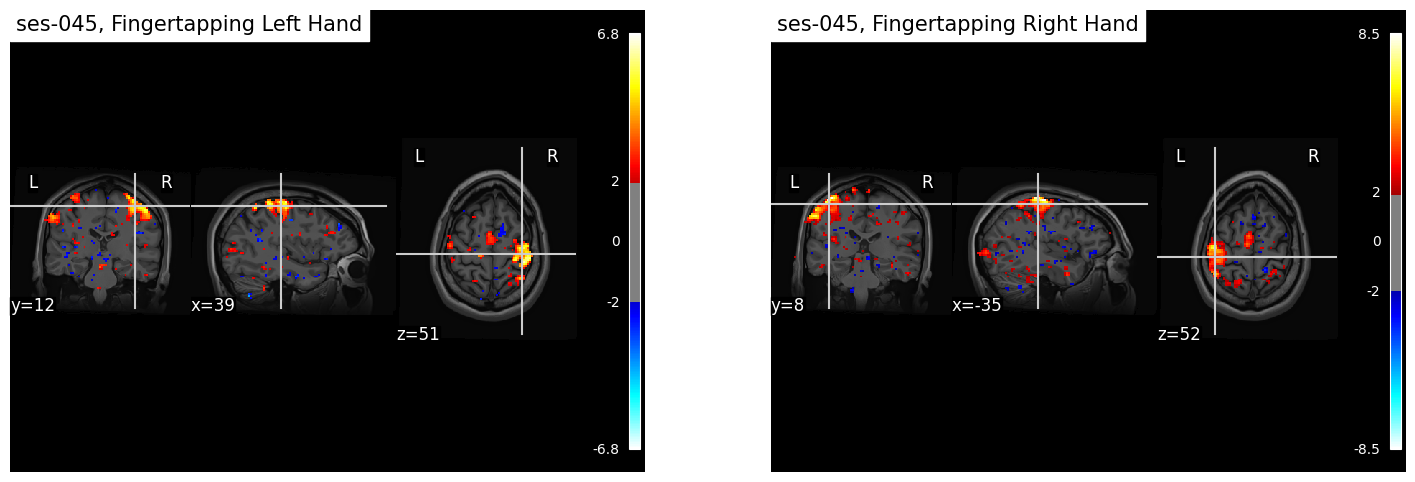

In [16]:
from nilearn.plotting import plot_stat_map

fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Load the T1w image
t1w_img = nb.load(t1w)

ses_idx = 32
z_map = first_level_models[ses_idx].compute_contrast(
    contrast_def="mot_L - blank", output_type="z_score"
)

ax = plot_stat_map(
    z_map,
    bg_img = t1w_img,
    threshold=2.0,
    black_bg=True,
    axes=ax1,
    title=f"{events_sessions[ses_idx]}, Fingertapping Left Hand",
)

z_map = first_level_models[ses_idx].compute_contrast(
    contrast_def="mot_R - blank", output_type="z_score"
)
ax = plot_stat_map(
    z_map,
    bg_img = t1w_img,
    threshold=2.0,
    black_bg=True,
    axes=ax2,
    title=f"{events_sessions[ses_idx]}, Fingertapping Right Hand",
)

The statistical map of this session first level model presents well the expected activation in the parietal motor cortex associated with the motor task. Moreover, you can see the symmetry linked to the change of hands: the left motor cortex activates when the right hand fingertaps and vice versa. 

That's the end of the first-level analysis. We obtained statistical maps of the voxels that are significantly activated or deactivated during particular tasks and those maps are in alignment with expectations. 

Now, we would like to see how those statistical maps compare across different phase encoding directions. We will do so by building a second-level model using *nilearn*.

## Compare activation maps across different phase encoding directions

In our dataset, we acquired many repetitions of the same QCT BOLD fMRI scan, using the same sequence with the exception of the phase encoding direction which varied. Our goal is to investigate how the change in the phase encoding direction influences the statistical maps on these very simple paradigms that constitute the QCT. This comparison can be implemented in *nilearn* using a second level model.

### Extract design matrix for second level analysis

The second level model, as the first level one, needs a design matrix that indicates to the model the variable it needs to pay attention to. In our case, the variable of interest that will drive the comparison is the phase encoding direction, so let us extract this parameter for each session into a dataframe.

In [17]:
from nilearn.glm.second_level import make_second_level_design_matrix

# Find the PE direction corresponding to each session. 
# It is stored in a TSV that we manually wrote.
PE = pd.read_csv(
    Path("/home/acionca/Documents/code/hcph-sops/code/physioconv/schedule.tsv"),
    sep="\t",
)

# Keep only one run per session and only the sessions 
# acquired so far
PE = PE.drop_duplicates(subset="session")

# This will drop the useless "run" column as well as 
# rows without AcqKnowledge files (i.e. not properly acquired)
PE = PE.drop(columns=["Run"]).dropna(axis="rows")

# Now we can create ses_df, the dataframe matching 
# the session name to the phase encoding direction, 
# using the previous dataframe. Also, we rename 
# the "sessions" column to match what Nilearn 
# is expecting (i.e. "subject_label")
ses_df = PE.loc[:, ["session", "PE"]].rename(columns={"session": "subject_label"})

A good practice for group analyses (and contrasts) is to use one-hot encoded groups (i.e. a columns with 1 if session is LR and 0 elsewhere, a column with 1 if session is RL, etc.). Those columns can then be assembled into the design matrix. Do not forget to visualize the matrix and verify that it has been built like you expected it to!

/home/cprovins/.local/lib/python3.11/site-packages/nilearn/glm/first_level/design_matrix.py:508: UserWarning: Attention: Design matrix is singular. Aberrant estimates are expected.
  warn(


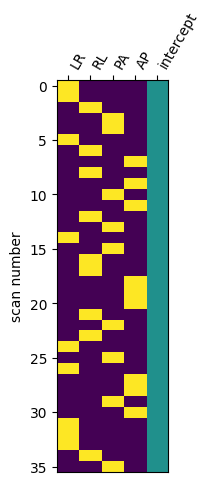

In [18]:
import re

# Create one hot-encoding column for each phase encoding direction
for pe_name in ["LR", "RL", "PA", "AP"]:
    ses_df[pe_name] = (ses_df.PE == pe_name).astype(int)

# Now the design matrix function uses two arguments: subjects_label (old 'ses_label') 
# and confounds (all PEs in our case). Also, we have to drop the `PE` column for it 
# to work properly (since it contains strings)
ses_df = ses_df.drop(columns=["PE"])

# Finally, we have to make sure the number of rows in the 2nd level design matrix 
# is the same as the number of first level images (i.e. sessions)
# You may comment the line below to see how the design matrix looks like 
# for all acquired sessions

# Get the session index for which we found QCT fMRIPrep derivatives
found_ses = [
    int(re.search(r"ses-0(\d\d)", s).group(1)) if re.search(r"ses-0\d\d", s) else None
    for s in qct_files
]

# Keep only sessions for which QCT fMRIPrep derivatives where found
ses_df = ses_df.loc[[ses in found_ses for ses in ses_df.subject_label]]

design_matrix_2nd = make_second_level_design_matrix(
    subjects_label=ses_df.subject_label, confounds=ses_df
)

# Plot design matrix
ax = plot_design_matrix(design_matrix_2nd)

The design matrix is indeed one-hot encoded.

### Fit GLM

We obtained the design matrix, as such we can fit the second level GLM to the BOLD data.

In [19]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(minimize_memory=False)
second_level_model = second_level_model.fit(
    first_level_models, design_matrix=design_matrix_2nd
)

### Obtain and plot statistical maps

As another safety check, we want to verify that regardless of the phase encoding direction, we can see a clear activation of the visual cortex for the visual gratting pattern and a clear difference of activation between right and left fingertapping.

In [20]:
from nilearn.glm import threshold_stats_img

# Visual grating activation
second_level_stat_map_vis = second_level_model.compute_contrast(
    second_level_contrast="RL + LR + AP + PA",
    first_level_contrast="vis - blank",
    output_type="all",
)
thesh_stat_img_vis, threshold_vis = threshold_stats_img(
    second_level_stat_map_vis["z_score"], alpha=0.05, height_control="fdr"
)

# Fingertapping activation
second_level_stat_map_mot = second_level_model.compute_contrast(
    second_level_contrast="RL + LR + AP + PA",
    first_level_contrast="mot_R - mot_L",
    output_type="all",
)

thesh_stat_img_mot, threshold = threshold_stats_img(
    second_level_stat_map_mot["z_score"], alpha=0.05, height_control="fdr"
)

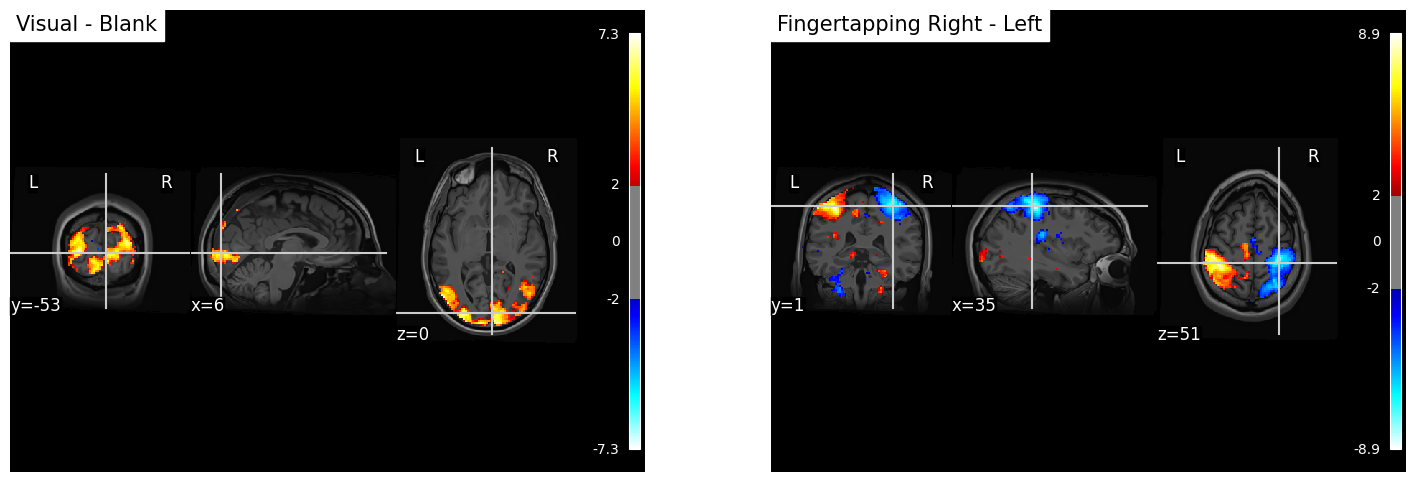

In [21]:
from nilearn.plotting import plot_stat_map

fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax = plot_stat_map(thesh_stat_img_vis, threshold= 2.0, bg_img=t1w_img, axes=ax1, black_bg=True, title="Visual - Blank")
ax = plot_stat_map(
    thesh_stat_img_mot, bg_img=t1w_img, threshold= 2.0, axes=ax2, black_bg=True, title="Fingertapping Right - Left"
)

The visual grating patterns visibly activate the visual cortex in the occipital lobe and the laterality of fingertapping task appears very clearly in the contralateral primary motor cortex. 

Now let's compare those maps given different phase encoding directions.

In [22]:
from nilearn.plotting import plot_stat_map

contrast_list = [
    "LR - RL",
    "AP - PA",
    "AP - LR",
    "AP - RL",
    "PA - RL",
    "PA - LR",
]

thesh_stat_img_all = []
for contrast in contrast_list:
    contrast_stat_map = second_level_model.compute_contrast(
        second_level_contrast=contrast,
        first_level_contrast="mot_R - mot_L",
        output_type="all",
    )
    thesh_stat_img, threshold = threshold_stats_img(
    contrast_stat_map["z_score"], alpha=0.05, height_control="fpr"
    )
    thesh_stat_img_all.append(thesh_stat_img)

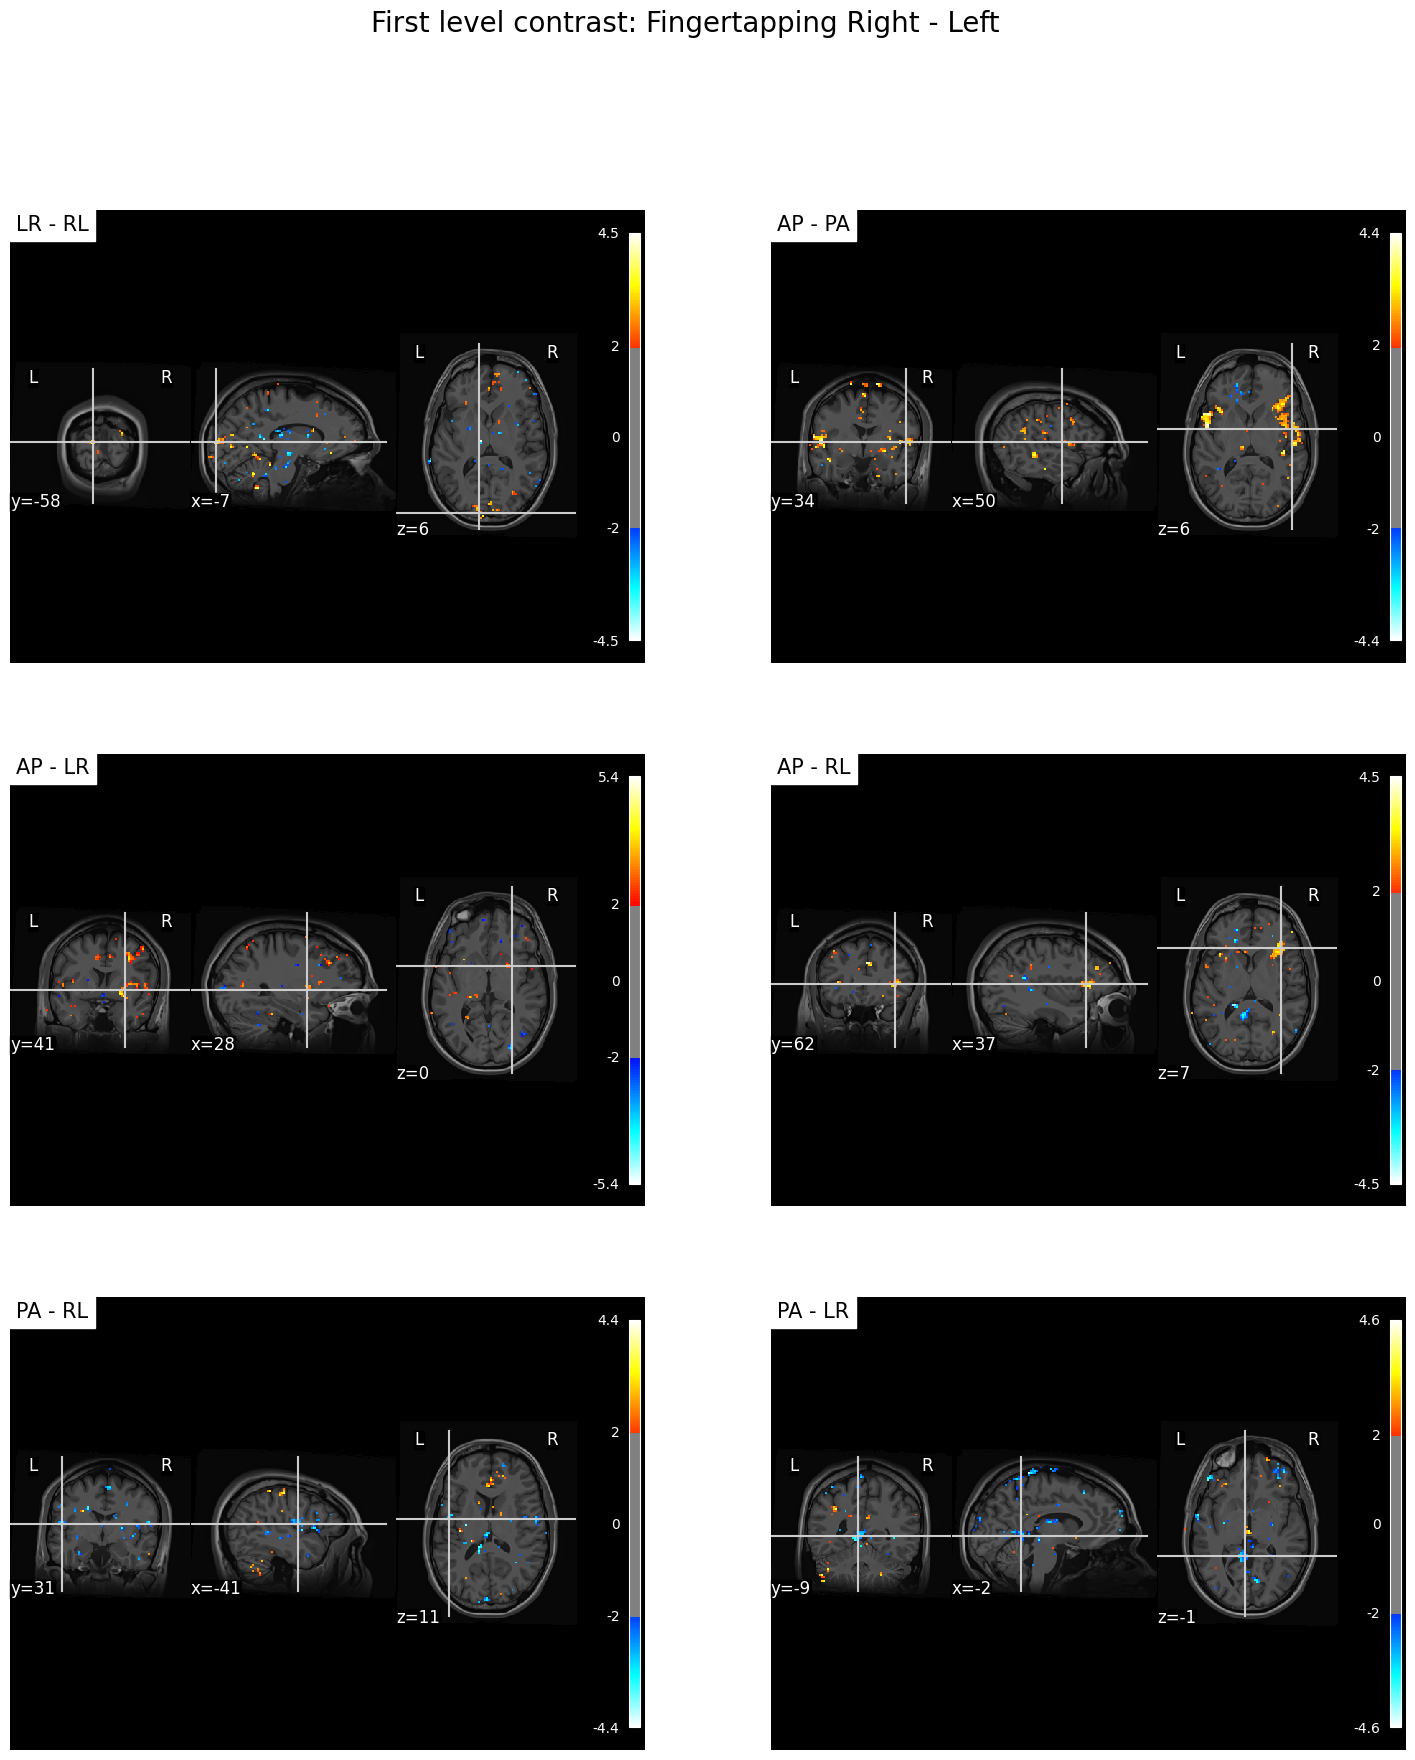

In [23]:
%matplotlib inline
fig = plt.figure(figsize=(18, 20))
fig.suptitle("First level contrast: Fingertapping Right - Left", fontsize=20)
gs = fig.add_gridspec(3, 2)

for i, (contrast, thesh_stat_img) in enumerate(zip(contrast_list, thesh_stat_img_all)):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    ax = plot_stat_map(thesh_stat_img, bg_img=t1w_img, threshold=2.0, black_bg=True, axes=ax, title=contrast)

In [24]:
from nilearn.plotting import plot_stat_map

contrast_list = [
    "LR - RL",
    "AP - PA",
    "AP - LR",
    "AP - RL",
    "PA - RL",
    "PA - LR",
]

thesh_stat_img_all = []
for contrast in contrast_list:
    contrast_stat_map = second_level_model.compute_contrast(
        second_level_contrast=contrast,
        first_level_contrast="vis - blank",
        output_type="all",
    )
    thesh_stat_img, threshold = threshold_stats_img(
    contrast_stat_map["z_score"], alpha=0.05, height_control="fpr"
    )
    thesh_stat_img_all.append(thesh_stat_img)

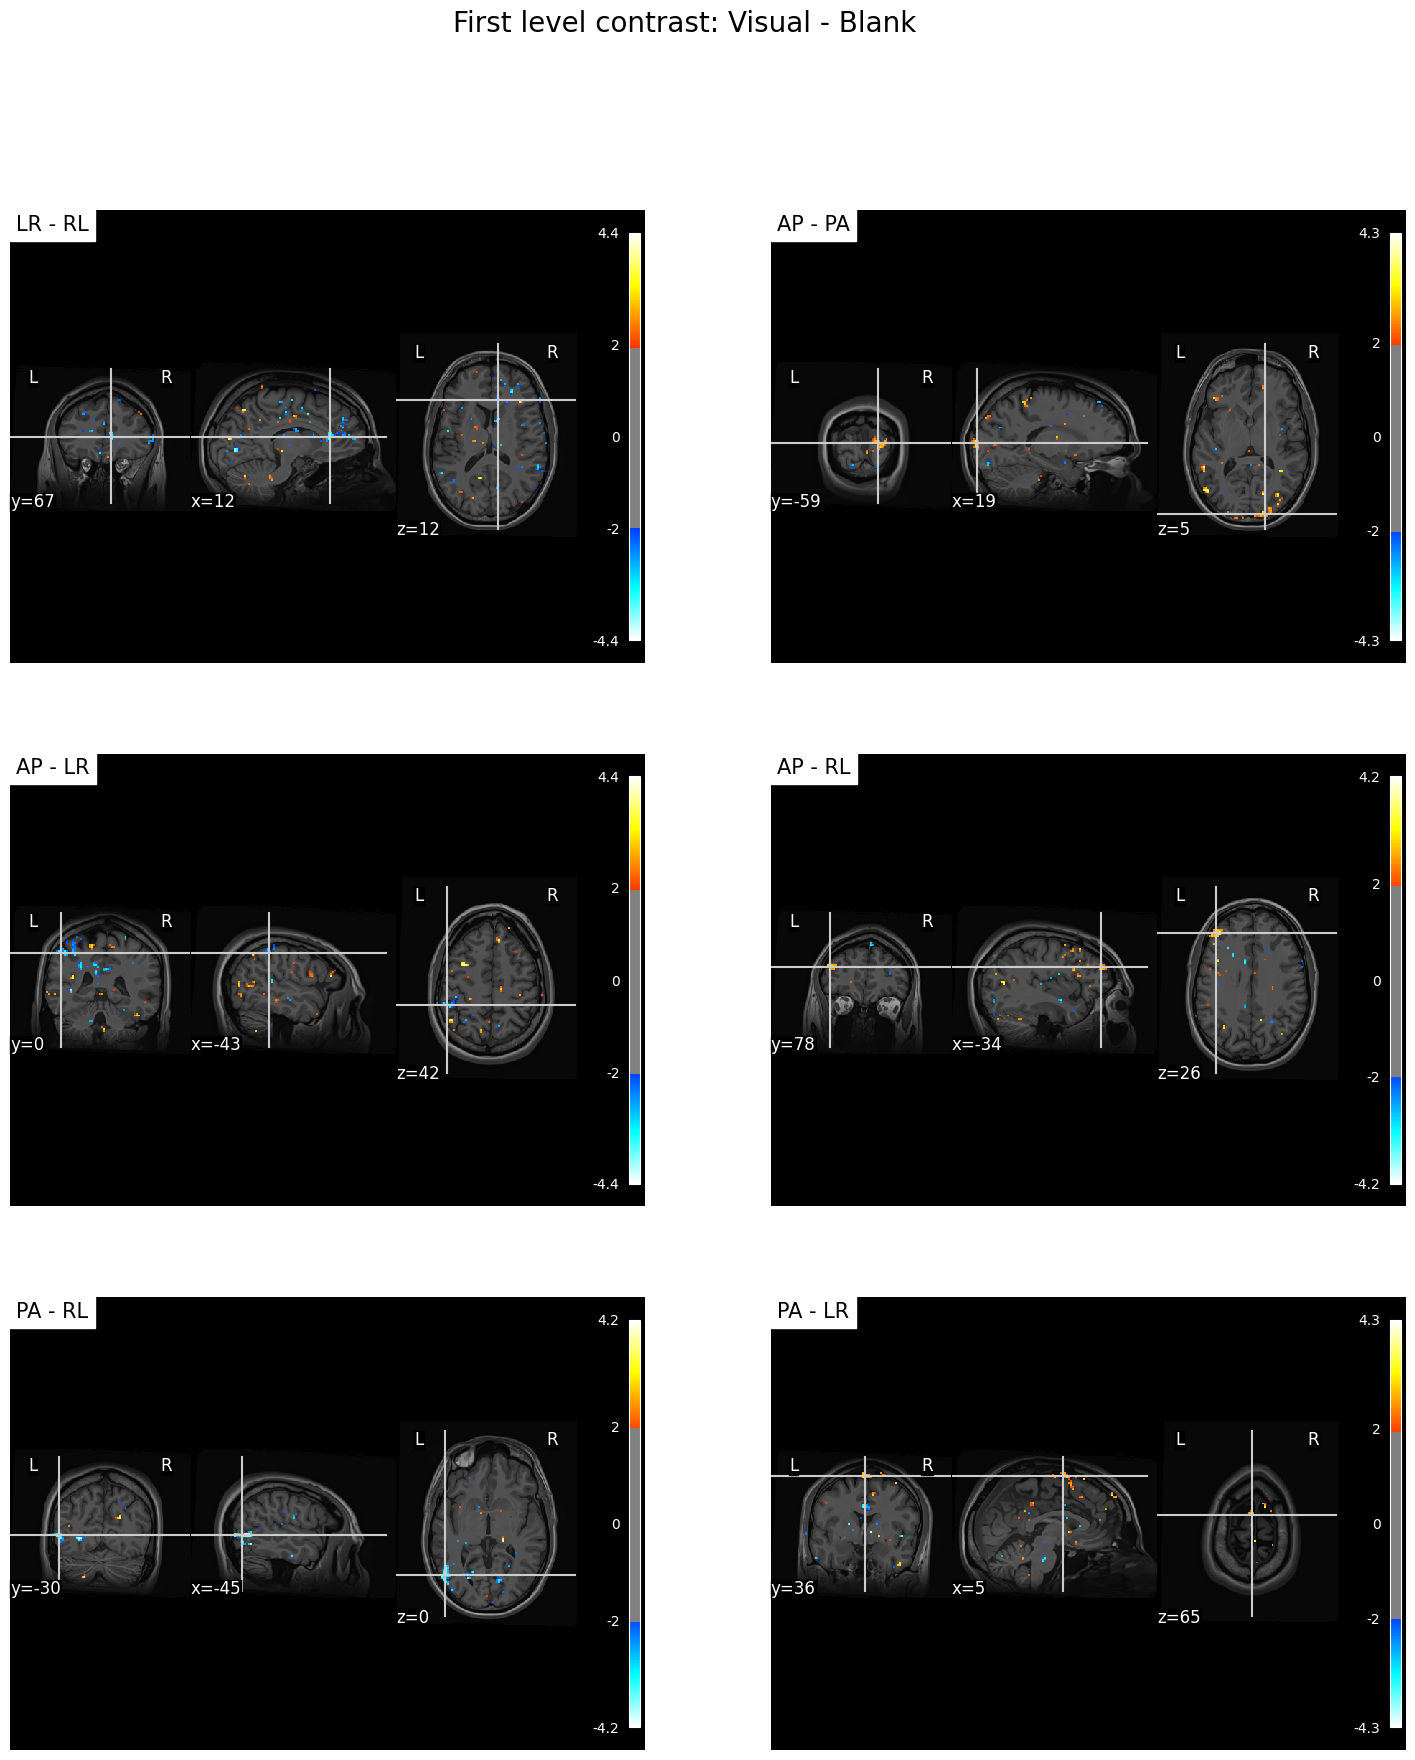

In [25]:
%matplotlib inline
fig = plt.figure(figsize=(18, 20))
fig.suptitle("First level contrast: Visual - Blank", fontsize=20)
gs = fig.add_gridspec(3, 2)

for i, (contrast, thesh_stat_img) in enumerate(zip(contrast_list, thesh_stat_img_all)):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    ax = plot_stat_map(thesh_stat_img, bg_img=t1w_img, threshold=2.0, black_bg=True, axes=ax, title=contrast)

We report all those contrasts in the supplementary material, but for the poster we single out one of the most interesting one.

<Figure size 1800x600 with 0 Axes>

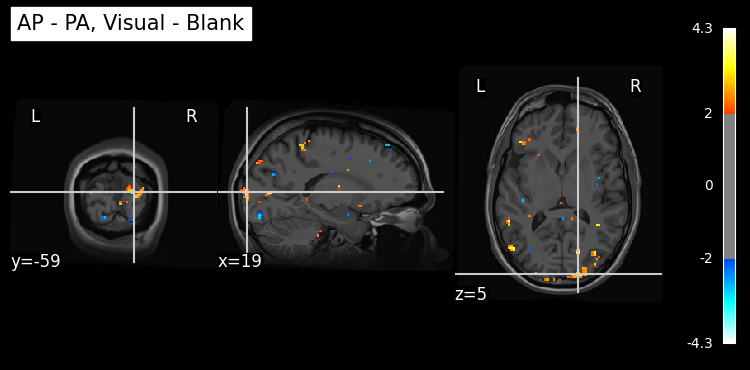

In [26]:
%matplotlib inline
fig = plt.figure(figsize=(18, 6))
#Get index of the contrast AP - PA
contrast = "AP - PA"
i = contrast_list.index(contrast)
ax = plot_stat_map(thesh_stat_img_all[i], bg_img=t1w_img, threshold=2.0, black_bg=True, title=contrast + ", Visual - Blank")
    